#**Addestramento di una rete Neurale basata su LSTM per la generazione di brani musicali**


#### Le seguenti sezioni sono state create al fine di rappresentare la parte principale del progetto di tesi. Essa consiste nell'addestramento di una rete neurale avendo a disposizione un dataset creato e pre-processato in precedenza in locale:
- L' uso di librerie come **TensorFlow e Keras** sono state usate per i task di machine learning svolti;
- L' uso della libreria **matplotlib** è stata usata per l'Analisi del modello addestrato. L'Analisi e la valutazione del modello è stato approfondito attraverso l'impiego di un altro notebook;
- La libreria **numpy** è stata usata per la memorizzazione dell'insieme di valori di metriche per la valutazione del modello riscontrati nella parte finale dell'addestramento;
- La libreria **pickle** è stata usata per l'estrazione dei dati dal dataset;

In [1]:
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import numpy as np
from keras.models import Sequential,load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.layers import concatenate
from keras.layers import Input
from keras.layers import Bidirectional

from keras.callbacks import ModelCheckpoint

from keras.optimizers import adam_v2

from keras import Model

###Estrazione delle principali risorse usate per lo scopo:
- modello
- dataset 

*N.B. qualora ci sia il bisogno di iniziare l'addestramento dall'inizio sarà necessario estrarre solo il dataset*

In [3]:
!apt-get install rar
#!unrar x "./model.rar" "./"
#!unrar x "./dataset_pickle.rar" "./"
#!unrar x "./dataset_all_trasposition_minimal_pickle.rar" "./"
!unrar x "./dataset_mini_all_trasposition_minimal_extend_pickle.rar" "./"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
rar is already the newest version (2:5.5.0-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from ./dataset_mini_all_trasposition_minimal_extend_pickle.rar

Creating    ./dataset_mini_all_trasposition_minimal_pickle            OK
Extracting  ./dataset_mini_all_trasposition_minimal_pickle/durations.pickle       0%  OK 
Extracting  ./dataset_mini_all_trasposition_minimal_pickle/notes.pickle       1%  OK 
Extracting  ./dataset_mini_all_trasposition_minimal_pickle/offsets.pickle       1%  OK 
Extracting  ./dataset_mini_all_trasposition_minimal_pickle/tempos.pickle       1%  OK 
Extracting  ./dataset_mini_all_trasposition_minimal_pickle/velocities.pickle       1%  OK 
Extracting  ./dataset_mini_all_trasposition_minimal_pickle/X_test.pickle       6%

## Prosecuzione Training partendo da un modello salvato

### INPUT

- cartella contenente le informazioni sul modello precedentemente salvato
- cartella contenente il dataset in formato .pickle splittato

### OUTPUT

- **grafici di loss e accuracy** complessiva del modello (per il numero di epoche eseguite)
- produzione di una cartella **'model_new'** contenente il modello aggiornato
- produzione di vari pesi con intestazione **'weights-improvement-numero_epoca-valore_di_loss_migliore-bigger.hdf5'**
- produzione di file *.npz* contenente le varie informazioni history dell'addestramento riguardo:
  1. **loss,accuracy e validation loss,accuracy complessiva del modello**
  2. **loss,accuracy e validation loss,accuracy per ogni feature esaminata**

*N.B. per aggiornare le risorse di input vedere ultima riga di tale blocco*

In [ ]:
def extract_sets (ROOT_PATH_DATA):
  X_train = load_set("X_train.pickle",ROOT_PATH_DATA)
  y_train = load_set("y_train.pickle",ROOT_PATH_DATA)
  X_validation = load_set("X_validation.pickle",ROOT_PATH_DATA)
  y_validation = load_set("y_validation.pickle",ROOT_PATH_DATA)

  return X_train,y_train,X_validation,y_validation

def load_set (name_set,path):
  filepath1 = open(path + "/" + name_set, 'rb')
  r_set = pickle.load(filepath1)
  return r_set

def evaluate_model(model,batch_size,X_test,y_test):
  # Evaluate the model on the test data using `evaluate`
  y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)

  y_pred_bool = np.argmax(np.array(y_pred[0]), axis=1)
  y_test_bool = np.argmax(np.array(y_test[0]), axis=1)

  print("------------------confusion matrix---------------------")

  cm = confusion_matrix(y_test_bool,y_pred_bool)
  labels = set(y_test_bool)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

  # figsize per modificare la grandezza della matrice di confusione
  fig, ax = plt.subplots(figsize=(35,35))
  disp.plot(cmap=plt.cm.Blues,ax=ax)
  plt.show()

  print("-------------------------------------------------------")

  print(classification_report(y_test_bool, y_pred_bool))

  print("-----------------Evaluate on test data-----------------")

  results = model.evaluate(X_test, y_test, batch_size=batch_size)
  print("test loss", results[0])
  print("test accuracy", (results[4] + results[5] + results[6])/3 )

  print("-------------------------------------------------------")

def plot_accuracy_validation(history):
  print(history.history.keys())
  complex_acc = [history.history['Note_acc'],history.history['Offset_acc'],history.history['Duration_acc'],history.history['Velocity_acc'],history.history['Tempo_acc']]
  summed_acc = list(map(sum, zip(*complex_acc)))
  
  complex_val_acc = [history.history['val_Note_acc'],history.history['val_Offset_acc'],history.history['val_Duration_acc'],history.history['val_Velocity_acc'],history.history['val_Tempo_acc']]
  summed_val_acc = list(map(sum, zip(*complex_val_acc)))
  
  n_feature = 5
  acc = [x / n_feature for x in summed_acc]
  val_acc = [x / n_feature for x in summed_val_acc]

  save_history_element("accuracy_training.npz",acc)
  save_history_element("val_accuracy_training.npz",val_acc)
  save_history_element("accuracy_features.npz",complex_acc)
  save_history_element("val_accuracy_features.npz",complex_val_acc)

  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()
  
def plot_loss_validation(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  complex_loss = [history.history['Note_loss'],history.history['Offset_loss'],history.history['Duration_loss'],history.history['Velocity_loss'],history.history['Tempo_loss']]
  complex_val_loss = [history.history['val_Note_loss'],history.history['val_Offset_loss'],history.history['val_Duration_loss'],history.history['val_Velocity_loss'],history.history['val_Tempo_loss']]

  save_history_element("loss_features.npz",complex_loss)
  save_history_element("val_loss_features.npz",complex_val_loss)
  save_history_element("loss_training.npz",loss)
  save_history_element("val_loss_training.npz",val_loss)

  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
 
def save_history_element(filename,array):
   np.savez_compressed(filename,array)

def continue_training(ROOT_PATH_DATA,PATH_MODEL,PATH_NEW_MODEL,epochs,batch_size,verbose):

  model = load_model(PATH_MODEL)
  #model.load_weights("weights-improvement-15-4.5236-bigger.hdf5")
  model.summary()
  X_train,y_train,X_validation,y_validation = extract_sets (ROOT_PATH_DATA)

  filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
  checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=verbose,
    save_best_only=True,
    mode='min'
  )
  callbacks_list = [checkpoint]
  """
  l'addestramenta avrà:
  - la serie di input estratte dalla parserizzazione dei file midi
  - la serie di output corrispondenti agli input estratti nella parserizzazione (OUTPUT NON DI PREDIZIONE)
  """
  #addestramento con dati di validation definiti in dati
  history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_validation,y_validation),
    epochs = epochs, 
    batch_size = batch_size,
    callbacks= callbacks_list
    )
  
  plot_accuracy_validation(history)
  plot_loss_validation(history)
  model.save(PATH_NEW_MODEL)
  """
  X_test = load_set("X_test.pickle", ROOT_PATH_DATA)
  y_test = load_set("y_test.pickle", ROOT_PATH_DATA)
  evaluate_model(model,batch_size,X_test,y_test)
  """
 
continue_training("dataset_mini_all_trasposition_minimal_pickle","model","model_new",15,128,0)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 1)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 16, 1)]      0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 16, 1)]      0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 16, 1)]      0           []                               
                                                                                              

## Addestramento con Core LSTM standard

### INPUT

- cartella contenente il dataset splittato composto da file in formato *.pickle*

### OUTPUT

- **grafici di loss e accuracy** complessiva del modello (per il numero di epoche eseguite)
- produzione di una cartella **'model'** contenente le informazioni sul modello creato
- produzione di vari pesi con intestazione **'weights-improvement-numero_epoca-valore_di_loss_migliore-bigger.hdf5'**
- produzione di file *.npz* contenente le varie informazioni history dell'addestramento riguardo:
  1. **loss,accuracy e validation loss,accuracy complessiva del modello**
  2. **loss,accuracy e validation loss,accuracy per ogni feature esaminata**

*N.B. per aggiornare le risorse di input vedere ultima riga di tale blocco*

read dataset...
create network skeleton
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 1)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 16, 1)]      0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 16, 1)]      0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 16, 1)]      0           []                               
                                                      

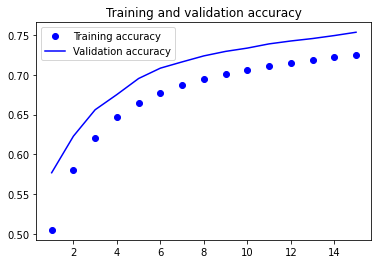

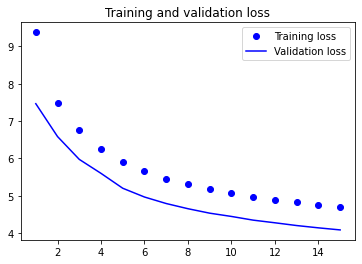

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [ ]:
def train_network(
  ROOT_PATH_DATA,PATH_MODEL,
  epochs,batch_size,verbose
  ):
    print ("read dataset...")
    X_train = load_set("X_train.pickle",ROOT_PATH_DATA)
    y_train = load_set("y_train.pickle",ROOT_PATH_DATA)
    X_validation = load_set("X_validation.pickle",ROOT_PATH_DATA)
    y_validation = load_set("y_validation.pickle",ROOT_PATH_DATA)
    #X_test = load_set("X_test.pickle",ROOT_PATH_DATA)
    #y_test = load_set("y_test.pickle",ROOT_PATH_DATA)
    X_test = []
    y_test = []    
    print("create network skeleton")
    
    model = create_network(
        X_train[0],y_train[0].shape[1],
        X_train[1], y_train[1].shape[1],
        X_train[2], y_train[2].shape[1],
        X_train[3], y_train[3].shape[1],
        X_train[4], y_train[4].shape[1]
    )

    print("prepare training...")
    
    
    train_with_validation_data(
        model,
        X_train,y_train,
        X_validation,y_validation,
        X_test,y_test,
        PATH_MODEL,epochs,batch_size,verbose
    )
  
    
def network_branch_to_consider(network_input):
  """
  si distinguono due tipologie di input (che sono output di tale funzione):
  inputin --> ESSI COSTITUISCONO IL NODO DI INPUT DELLA RETE NEURALE E NON PER LA COSTRUZIONE DEL MODELLO
  inputLayer -->  input utili alla costruzione del modello Model (DEFINIZIONE DELLO SPAZIO RISERVATO ALL'INPUT)
  """
  inputLayer = Input(shape=(network_input.shape[1], network_input.shape[2]))
  inputin = LSTM(
    256,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
  )(inputLayer)
  inputin = Dropout(0.5)(inputin)

  return inputin,inputLayer

def network_branch_to_classify(string_desc,result_RNN,n_vocab):
  """
  il risultato di tale funzione COSTITUISCE IL NODO DI OUTPUT DELLA RETE NEURALE
  """
  output = Dense(128, activation='relu')(result_RNN)
  output = BatchNorm()(output)
  output = Dropout(0.5)(output)
  output = Dense(n_vocab, activation='softmax', name=string_desc)(output)
  return output

def create_network(
    network_input_notes,n_vocab_notes,
    network_input_offsets, n_vocab_offsets,
    network_input_durations, n_vocab_durations,
    network_input_velocities, n_vocab_velocities,
    network_input_tempos, n_vocab_tempos
    ):
  """
  in tale funzione network_input_notes,network_input_offsets,network_input_durations sono usati
  ESCLUSIVAMENTE NON PER IL LORO CONTENUTO MA PER LE LORO DIMENSIONI O SHAPE
  """

  #costruzione dei due differenti input
  inputNotes,inputNotesLayer = network_branch_to_consider(network_input_notes)
  inputOffsets,inputOffsetsLayer = network_branch_to_consider(network_input_offsets)
  inputDurations,inputDurationsLayer = network_branch_to_consider(network_input_durations)
  inputVelocities,inputVelocitiesLayer = network_branch_to_consider(network_input_velocities)
  inputTempos,inputTemposLayer = network_branch_to_consider(network_input_tempos)

  # concatenazione degli input da dare in pasto alla rete neurale GRU
  inputs = concatenate([inputNotes, inputOffsets, inputDurations,inputVelocities,inputTempos])

  # costruzione della GRU proposta nel documento per considerare cosa ha imparato nei tre differenti Branches

  x = LSTM(512, return_sequences=True)(inputs)
  x = Dropout(0.5)(x)
  x = LSTM(512)(x)
  x = BatchNorm()(x)
  x = Dropout(0.5)(x)
  x = Dense(256, activation='relu')(x)

  outputNotes = network_branch_to_classify("Note",x,n_vocab_notes)
  outputOffsets = network_branch_to_classify("Offset",x,n_vocab_offsets)
  outputDurations = network_branch_to_classify("Duration",x,n_vocab_durations)
  outputVelocities = network_branch_to_classify("Velocity",x,n_vocab_velocities)
  outputTempos = network_branch_to_classify("Tempo",x,n_vocab_tempos)

  model = Model(
    inputs=[inputNotesLayer, inputOffsetsLayer, inputDurationsLayer,inputVelocitiesLayer,inputTemposLayer], 
    outputs=[outputNotes, outputOffsets, outputDurations,outputVelocities,outputTempos]
  )

  #compilazione del modello
  model.compile(
    loss='categorical_crossentropy',
    metrics= ['acc'],
    optimizer='adam'
  )
  # Useful to try RMSProp though
  #model.compile(loss='categorical_crossentropy', optimizer= "RMSprop")
  model.summary()
  return model


def train_with_validation_data(
	model, 
	X_train,y_train,
	X_val,y_val,
  X_test,y_test,
	PATH_MODEL,epochs,batch_size,verbose):
	
  """
  in tale funzione di training i dati di input e di output vengono immessi 
  ESCLUSIVAMENTE CONSIDERANDO IL LORO CONTENUTO
  """
  filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"

  checkpoint_loss = ModelCheckpoint(
    filepath,
    period = 10,
    monitor='loss',
    verbose=verbose,
    save_best_only=True,
    mode='min'
  )

  callbacks_list = [checkpoint_loss]
  """
  l'addestramenta avrà:
  - la serie di input estratte dalla parserizzazione dei file midi
  - la serie di output corrispondenti agli input estratti nella parserizzazione (OUTPUT NON DI PREDIZIONE)
  """
  #addestramento con dati di validation definiti in dati
  history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_val,y_val),
    epochs = epochs, 
    batch_size = batch_size,
    callbacks= callbacks_list
    )
  #evaluate_model(model,batch_size,X_test,y_test)
  plot_accuracy_validation(history)
  plot_loss_validation(history)

  model.save(PATH_MODEL)

def plot_accuracy_validation(history):
  print(history.history.keys())
  complex_acc = [history.history['Note_acc'],history.history['Offset_acc'],history.history['Duration_acc'],history.history['Velocity_acc'],history.history['Tempo_acc']]
  summed_acc = list(map(sum, zip(*complex_acc)))
  
  complex_val_acc = [history.history['val_Note_acc'],history.history['val_Offset_acc'],history.history['val_Duration_acc'],history.history['val_Velocity_acc'],history.history['val_Tempo_acc']]
  summed_val_acc = list(map(sum, zip(*complex_val_acc)))
  
  n_feature = 5
  acc = [x / n_feature for x in summed_acc]
  val_acc = [x / n_feature for x in summed_val_acc]

  save_history_element("accuracy_features.npz",complex_acc)
  save_history_element("val_accuracy_features.npz",complex_val_acc)

  save_history_element("accuracy_training.npz",acc)
  save_history_element("val_accuracy_training.npz",val_acc)

  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()
  
def plot_loss_validation(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  complex_loss = [history.history["Note_loss"],history.history["Offset_loss"],history.history["Duration_loss"],history.history["Velocity_loss"],history.history["Tempo_loss"]]
  complex_val_loss = [history.history["val_Note_loss"],history.history["val_Offset_loss"],history.history["val_Duration_loss"],history.history["val_Velocity_loss"],history.history["val_Tempo_loss"]]

  save_history_element("loss_features.npz",complex_loss)
  save_history_element("val_loss_features.npz",complex_val_loss)

  save_history_element("loss_training.npz",loss)
  save_history_element("val_loss_training.npz",val_loss)

  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
def load_set (name_set,path):
    filepath1 = open(path + "/" + name_set, 'rb')
    r_set = pickle.load(filepath1)
    return r_set

def save_history_element(filename,array):
   np.savez_compressed(filename,array)

train_network(
    "dataset_mini_all_trasposition_minimal_pickle","model",
	  15,128,0
    )
